```
streamlit run your_script.py [-- script args]
```

In [52]:
%%writefile offozaynapp/main.py

import streamlit as st
import pandas as pd
import numpy as np

st.title('Offshore Leaks')


DATE_COLUMN = 'date/time'
DATA_URL = ('https://s3-us-west-2.amazonaws.com/'
         'streamlit-demo-data/uber-raw-data-sep14.csv.gz')

@st.cache
def load_data(nrows):
    data = pd.read_csv(DATA_URL, nrows=nrows)
    lowercase = lambda x: str(x).lower()
    data.rename(lowercase, axis='columns', inplace=True)
    data[DATE_COLUMN] = pd.to_datetime(data[DATE_COLUMN])
    return data


# Create a text element and let the reader know the data is loading.
data_load_state = st.text('Loading data...')
# Load 10,000 rows of data into the dataframe.
data = load_data(10000)
# Notify the reader that the data was successfully loaded.
#data_load_state.text('Loading data...done!')
data_load_state.text("Done! (using st.cache)")

if st.checkbox('Show raw data'):
    st.subheader('Raw data')
    st.write(data.head())

st.subheader('Number of pickups by hour')

hist_values = np.histogram(
    data[DATE_COLUMN].dt.hour, bins=24, range=(0,24))[0]

st.write(hist_values)

st.bar_chart(hist_values)

st.subheader('Map of all pickups')

st.map(data)

hour_to_filter = 17
filtered_data = data[data[DATE_COLUMN].dt.hour == hour_to_filter]
st.subheader(f'Map of all pickups at {hour_to_filter}:00')
st.map(filtered_data)

hour_to_filter = st.slider('hour', 0, 23, 17)  # min: 0h, max: 23h, default: 17h

Overwriting offozaynapp/main.py


In [44]:
%%writefile offozaynapp/config.py

sheet_url = 'https://docs.google.com/spreadsheets/d/10qMx2LXQkjOMX_lB2LHWVi8OzI_-HaN0/edit?usp=sharing&ouid=111709418728007906825&rtpof=true&sd=true'

lat_lon_url = 'https://drive.google.com/file/d/10l-06L2waxvG6pKbCwuX1wtPtrPjgPO4/view?usp=sharing'

Overwriting offozaynapp/config.py


In [4]:
%%writefile __init__.py




Writing __init__.py


In [78]:
%%writefile offozaynapp/tools.py

import config
import streamlit as st
import graphviz as graphviz
import pandas as pd
import networkx as nx
from PIL import Image
import platform

# Taken with modification from
# https://newbedev.com/pandas-how-to-read-csv-file-from-google-drive-public"""
get_url = lambda u: 'https://drive.google.com/uc?export=download&id=' + u.split('/')[-2]
    

def check_platform():
    pl = platform.platform()
    if pl.startswith('macOS'):
        return 'local'
    return 'remote'
    
    
@st.cache
def load_data(url, nrows):
    data = pd.read_csv(get_url(url), nrows=nrows) 
    return data

@st.cache
def load_lat_lon(nrows):
    if check_platform()=='remote':
        return pd.read_csv(get_url(config.lat_lon_url), nrows=nrows) 
    else:
        return pd.read_csv('./data/nodes_lat_lon.csv', nrows=nrows) 


@st.cache(suppress_st_warning=True)
def read_xlsx(sheet, nrows=10000):
    if check_platform()=='remote':
        return pd.read_excel(get_url(config.sheet_url), sheet_name=sheet, nrows=nrows)
    else:
        return pd.read_excel('./data/specific_edges.xlsx', sheet_name=sheet, nrows=nrows)


def create_digraph_new(df, count=10):   
    """
    https://discuss.streamlit.io/t/support-for-networkx-pyvis-and-folium/190/2
    """
    final_count = min(df.shape[0], count)
    df.sort_values(by='weight', ascending=False, inplace=True)
    G = nx.DiGraph()
    G.add_weighted_edges_from([tuple(x) for x in df.head(final_count).values])
    dot = nx.nx_pydot.to_pydot(G)
    st.graphviz_chart(dot.to_string())
    
def show_image(name, caption):
    image = Image.open(f'images/{name}')
    st.image(image, caption=caption)

    

Overwriting offozaynapp/tools.py


In [2]:
%%writefile offozaynapp/main.py

import tools
import streamlit as st
import pandas as pd
import numpy as np
import platform

st.set_page_config(page_title="Offshore Leaks Exploration")


st.title('Offshore Leaks')

#st.write(platform.platform())

select_list = ['', 'jurisdiction', 'countries', 'country_codes', 'continents', 'company_type', 'jurisdiction_description', 'table']
select_dict = {k.replace('_', ' ').title(): k for k in select_list}


select_key = st.sidebar.selectbox(
    "Which field would you like to explore?",
    tuple(select_dict.keys())
)

select_value = select_dict[select_key]

if select_value:
    st.write(select_value)
    
    if select_value == 'countries':
        tools.show_image('top_25_countries__address__intermediary__officer__entity.png', 'Countries')



    data = tools.read_xlsx(select_value)
    st.subheader('Raw data')
    st.write(data.head())


    if st.checkbox('Show raw data'):
        st.subheader(f'{select_key} Source')
        hist_values = data[f'{select_value}_source'].value_counts().sort_values(ascending=False)
        n_columns = st.slider('How many columns?', 0, hist_values.shape[0], min(15, hist_values.shape[0]))
        st.bar_chart(hist_values.head(n_columns))
        st.write(hist_values)


    n_edges = st.slider('How many edges?', 0, data.shape[0], min(100, data.shape[0]))
    tools.create_digraph_new(data, n_edges)
    
if st.checkbox('Show Latitude & Longitude data'):
    lat_lon_data = tools.load_lat_lon(10000)
    st.subheader('Raw data')
    st.write(lat_lon_data.head())
    st.map(lat_lon_data)

Overwriting offozaynapp/main.py


In [66]:
%%writefile offozaynapp/requirements.txt

graphviz
pydot
openpyxl
networkx

Overwriting offozaynapp/requirements.txt


In [ ]:
!pip install graphivz

In [59]:
import pandas as pd


orig_url = 'https://docs.google.com/spreadsheets/d/10qMx2LXQkjOMX_lB2LHWVi8OzI_-HaN0/edit?usp=sharing&ouid=111709418728007906825&rtpof=true&sd=true'
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id


xls = pd.ExcelFile(dwn_url)
df1 = pd.read_excel(xls, 'jurisdiction')


In [60]:
df1

,jurisdiction_source,jurisdiction_target,weight
0,BERMU,XXX,1
1,BVI,BVI,156
2,BVI,COOK,10
3,BVI,LABUA,5
4,BVI,MALAY,4
5,BVI,MAURI,2
6,BVI,SGP,9
7,CAYMN,XXX,84
8,COOK,BVI,10
9,COOK,COOK,201


In [1]:
import graphviz

In [58]:
#!conda install -c anaconda graphviz -y
#!conda install -c anaconda pydot -y
#!conda install -c anaconda openpyxl -y

In [10]:
ls ../data/clean/graphs

company_type.edgelist*             jurisdiction.edgelist*
continents.edgelist*               jurisdiction_description.edgelist*
countries.edgelist*                node_id.edgelist*
country_codes.edgelist*            table.edgelist*


In [18]:
import networkx as nx

url = 'https://drive.google.com/file/d/10eXidO511doY2M7dLQMZE00lGSVu_Vez/view?usp=sharing'
get_url = lambda u: 'https://drive.google.com/uc?export=download&id=' + u.split('/')[-2]

df = pd.read_csv(get_url(url))

In [19]:
import networkx as nx
G = nx.DiGraph()
G.add_weighted_edges_from([tuple(x) for x in df.values])

In [20]:
G

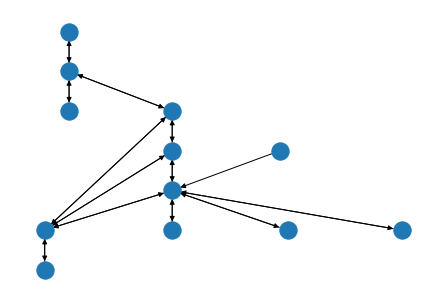

In [32]:
pos = nx.nx_pydot.graphviz_layout(G)
pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
nx.draw(G, pos)